In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=5
%env DWAVE_API_TOKEN=4Fq8-98e991a786ff04f4f4b6ab5466629411358ce418
%config InlineBackend.figure_format = 'retina'
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: DWAVE_API_TOKEN=4Fq8-98e991a786ff04f4f4b6ab5466629411358ce418
Fri Mar  7 06:20:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:1B:00.0 Off |                  Off |
| 30%   30C    P8             22W /  300W |       5MiB /  49140MiB |      0%      Default |
|                                      

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[06:21:01.425] INFO   CaloQVAE                                          Willkommen!
[06:21:01.427] INFO   CaloQVAE                                          Loading configuration.
[06:21:02.856] INFO   numexpr.utils                                     Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[06:21:02.858] INFO   numexpr.utils                                     Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[06:21:02.859] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2025-03-07 06:21:03,516 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[06:21:03.516] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [5]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")
# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
config.model.n_layers_per_subdec = 11
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

[06:25:25.353] INFO   data.dataManager                                  Loading Data
[06:25:45.462] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2ee47d7730>: 80000 events, 625 batches
[06:25:45.465] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2ee47d7fa0>: 10000 events, 10 batches
[06:25:45.466] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2ee47d7fd0>: 10000 events, 10 batches
[06:25:47.582] INFO   models.modelCreator                               Initialising Model Type AtlasConditionalQVAE3DHD
2025-03-07 06:25:47,594 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[06:25:47.594] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2025-03-07 06:25:52,097 dwave.cloud.client.base INFO  MainThread Receive

Initializing NetworkV3
Layer Inputs:  [1208, 2792, 2792, 2792]
Layer Outputs:  [1584, 1584, 1584, 6480]
Raw Layer Indices:  [0, 1584, 1584, 1584, 6480]
Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3


In [6]:
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])
wandb.watch(model)
engine=instantiate(config.engine, config)
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[06:26:00.707] INFO   wandb                                             Watching
/home/luian1/.local/lib/python3.10/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[06:26:01.342] INFO   engine.engineAtlas                                Setting up engine Atlas.
[06:26:01.343] INFO   engine.engineCaloV3                               Setting up engine Calo.
[06:26:01.344] INFO   engine.engine                                     Setting up default engine.


In [10]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[06:27:26.088] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f314812eb30>: 80000 events, 625 batches
[06:27:26.090] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2ee549eb90>: 10000 events, 10 batches
[06:27:26.090] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f2d98955ea0>: 10000 events, 10 batches


In [7]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            print(local_module_keys)
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

import sys
sys.path.append('/path/to/project')

import utils.plotting.HighLevelFeatures as HLF
import h5py
from ipynb.fs.full.utils.plotting.HEPMetrics import get_fpd_kpd_metrics

In [11]:
def search_HEPMetric(path_head, model_name, start_epoch, end_epoch, epoch_int):
    en_list = []
    fpd_recon, fpd_sample = [], []
    kpd_recon, kpd_sample = [], []
    hlf, ref_hlf = None, None
    for en in range(start_epoch, end_epoch, epoch_int):
        run_path = path_head + str(en) + ".pth"
        modelname = model_name
        datascaled = 'reduced'
        open_path = path_head.replace(path_head.split('/')[-1], '') + "config.yaml"
        with open(open_path, 'r') as file:
            model_config = yaml.safe_load(file)
            R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
            reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
            scaled=False
            
        arch = config['model']['model_type']
        part = config['data']['particle_type']
        modelCreator.load_state(run_path, dev)
        engine.model.eval();

        # get the samples
        xtarget_samples = []
        xrecon_samples = []
        xgen_samples = []
        xgen_samples_qpu = []
        n_samples4_qpu = 200
        
        # xrecon_samples_2 = []
        
        # labelstarget_samples = []
        # labelsrecon_samples = []
        entarget_samples = []
        with torch.no_grad():
            for xx in train_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            for xx in val_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            for xx in test_loader:
            # for xx in train_loader:
                in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
                ###############################################
                # true_energy = true_energy[:n_samples4_qpu,:]
                # in_data = in_data[:n_samples4_qpu,:]
                ##############################################
                # print(in_data.shape)
                if reducedata:
                    in_data = engine._reduce(in_data, true_energy, R=R)
                fwd_output = engine.model((in_data, true_energy), False)
                if reducedata:
                    in_data = engine._reduceinv(in_data, true_energy, R=R)
                    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
                    # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
                elif scaled:
                    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
                    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
                    # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    
                    if True:
                        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
                    else:
                        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                        # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
                    # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
                else:
                    in_data = in_data.detach().cpu()*1000
                    recon_data = fwd_output.output_activations.detach().cpu()*1000
                    engine._model.sampler._batch_size = true_energy.shape[0]
                    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
                    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
                    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
                    sample_data = sample_data.detach().cpu()*1000
        
        
                xtarget_samples.append(in_data.detach().cpu())
                xrecon_samples.append( recon_data.detach().cpu())
                xgen_samples.append( sample_data.detach().cpu())
                # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
                entarget_samples.append(true_energy.detach().cpu())
        
                # xrecon_samples_2.append( recon_data_2.detach().cpu())
            
            
        xtarget_samples = torch.cat(xtarget_samples, dim=0)
        xrecon_samples = torch.cat(xrecon_samples, dim=0)
        xgen_samples = torch.cat(xgen_samples, dim=0)
        # xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
        entarget_samples = torch.cat(entarget_samples, dim=0)
        
        # xrecon_samples_2 = torch.cat(xrecon_samples_2, dim=0)
        if en == start_epoch:
            print("First epoch")
            hlf = HLF.HighLevelFeatures('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)
            ref_hlf = HLF.HighLevelFeatures('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)
            hlf.Einc = entarget_samples

        recon_HEPMetrics = get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xrecon_samples), False, hlf, ref_hlf)
        sample_HEPMetrics = get_fpd_kpd_metrics(np.array(xtarget_samples), np.array(xgen_samples), False, hlf, ref_hlf)

        en_list.append(en)
        fpd_recon.append(recon_HEPMetrics[0])
        kpd_recon.append(recon_HEPMetrics[2])
        fpd_sample.append(sample_HEPMetrics[0])
        kpd_sample.append(sample_HEPMetrics[2])
        print("Finished generating HEP Metrics for epoch " + str(en) + " ...")
    return en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample

In [ ]:
path_head = "/fast_scratch_1/caloqvae/luian1/wandb/run-20250303_055603-lix04if8/files/AtlasConditionalQVAE3DHD_atlas_default_"
model_name = 'solar-firebrand-647'
HEPMetric_output = search_HEPMetric(path_head, model_name, 10, 191, 10)

[06:27:26.129] INFO   models.modelCreator                               Loading state
[06:27:26.442] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250303_055603-lix04if8/files/AtlasConditionalQVAE3DHD_atlas_default_10.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
First epoch
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 574.3716 ± 1.8048
KPD (x10^3): 1.7564 ± 0.1258
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[06:39:10.208] INFO   models.modelCreator                               Loading state


FPD (x10^3): 634.0750 ± 2.0566
KPD (x10^3): 1.9473 ± 0.0841
Finished generating HEP Metrics for epoch 10 ...


[06:39:10.693] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250303_055603-lix04if8/files/AtlasConditionalQVAE3DHD_atlas_default_20.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 526.6813 ± 2.1452
KPD (x10^3): 1.6265 ± 0.2646
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[06:55:07.115] INFO   models.modelCreator                               Loading state


FPD (x10^3): 663.4648 ± 3.2421
KPD (x10^3): 2.2495 ± 0.4338
Finished generating HEP Metrics for epoch 20 ...


[06:55:07.546] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250303_055603-lix04if8/files/AtlasConditionalQVAE3DHD_atlas_default_30.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
TESTING HELLO
Data contains NaNs or Infs. Handling them...
FPD (x10^3): 552.4068 ± 2.2696
KPD (x10^3): 1.6619 ± 0.2739
TESTING HELLO
Data contains NaNs or Infs. Handling them...


[07:10:11.985] INFO   models.modelCreator                               Loading state


FPD (x10^3): 625.0827 ± 3.6865
KPD (x10^3): 2.0493 ± 0.3580
Finished generating HEP Metrics for epoch 30 ...


[07:10:12.360] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20250303_055603-lix04if8/files/AtlasConditionalQVAE3DHD_atlas_default_40.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


[0.5743715983153219, 0.5266812542594178, 0.5524067573211366, 0.5399575982153986, 0.5375374725715795, 0.5269179676968201, 0.552643356988102, 0.5224038885797831, 0.5692257924722228, 0.5298427687811916, 0.5177034000940408, 0.4829729210669462, 0.45242500845079003, 0.4332480364548266, 0.45409619689003494, 0.44583834045574555, 0.4709292939792628, 0.45056004350856876, 0.4528339942851846] [0.0017563925826338256, 0.0016265386498541812, 0.0016619221637470538, 0.0014802270747735768, 0.001626013405347404, 0.0016162860108199784, 0.002274886758550254, 0.001972656511584736, 0.0021880781172956, 0.0026141254190283902, 0.0019679367964804406, 0.0018194716985215909, 0.0018493217520527683, 0.0017468910721973874, 0.0020196942434824727, 0.0022787637853538545, 0.0029203396302011075, 0.0019405812979278458, 0.002738627709647945] [0.6340750192643474, 0.6634647937340336, 0.6250826561705985, 0.604657453152671, 0.5768301233552284, 0.661369383114132, 0.5528745806728821, 0.6132791487678578, 0.8335492874686207, 0.6547

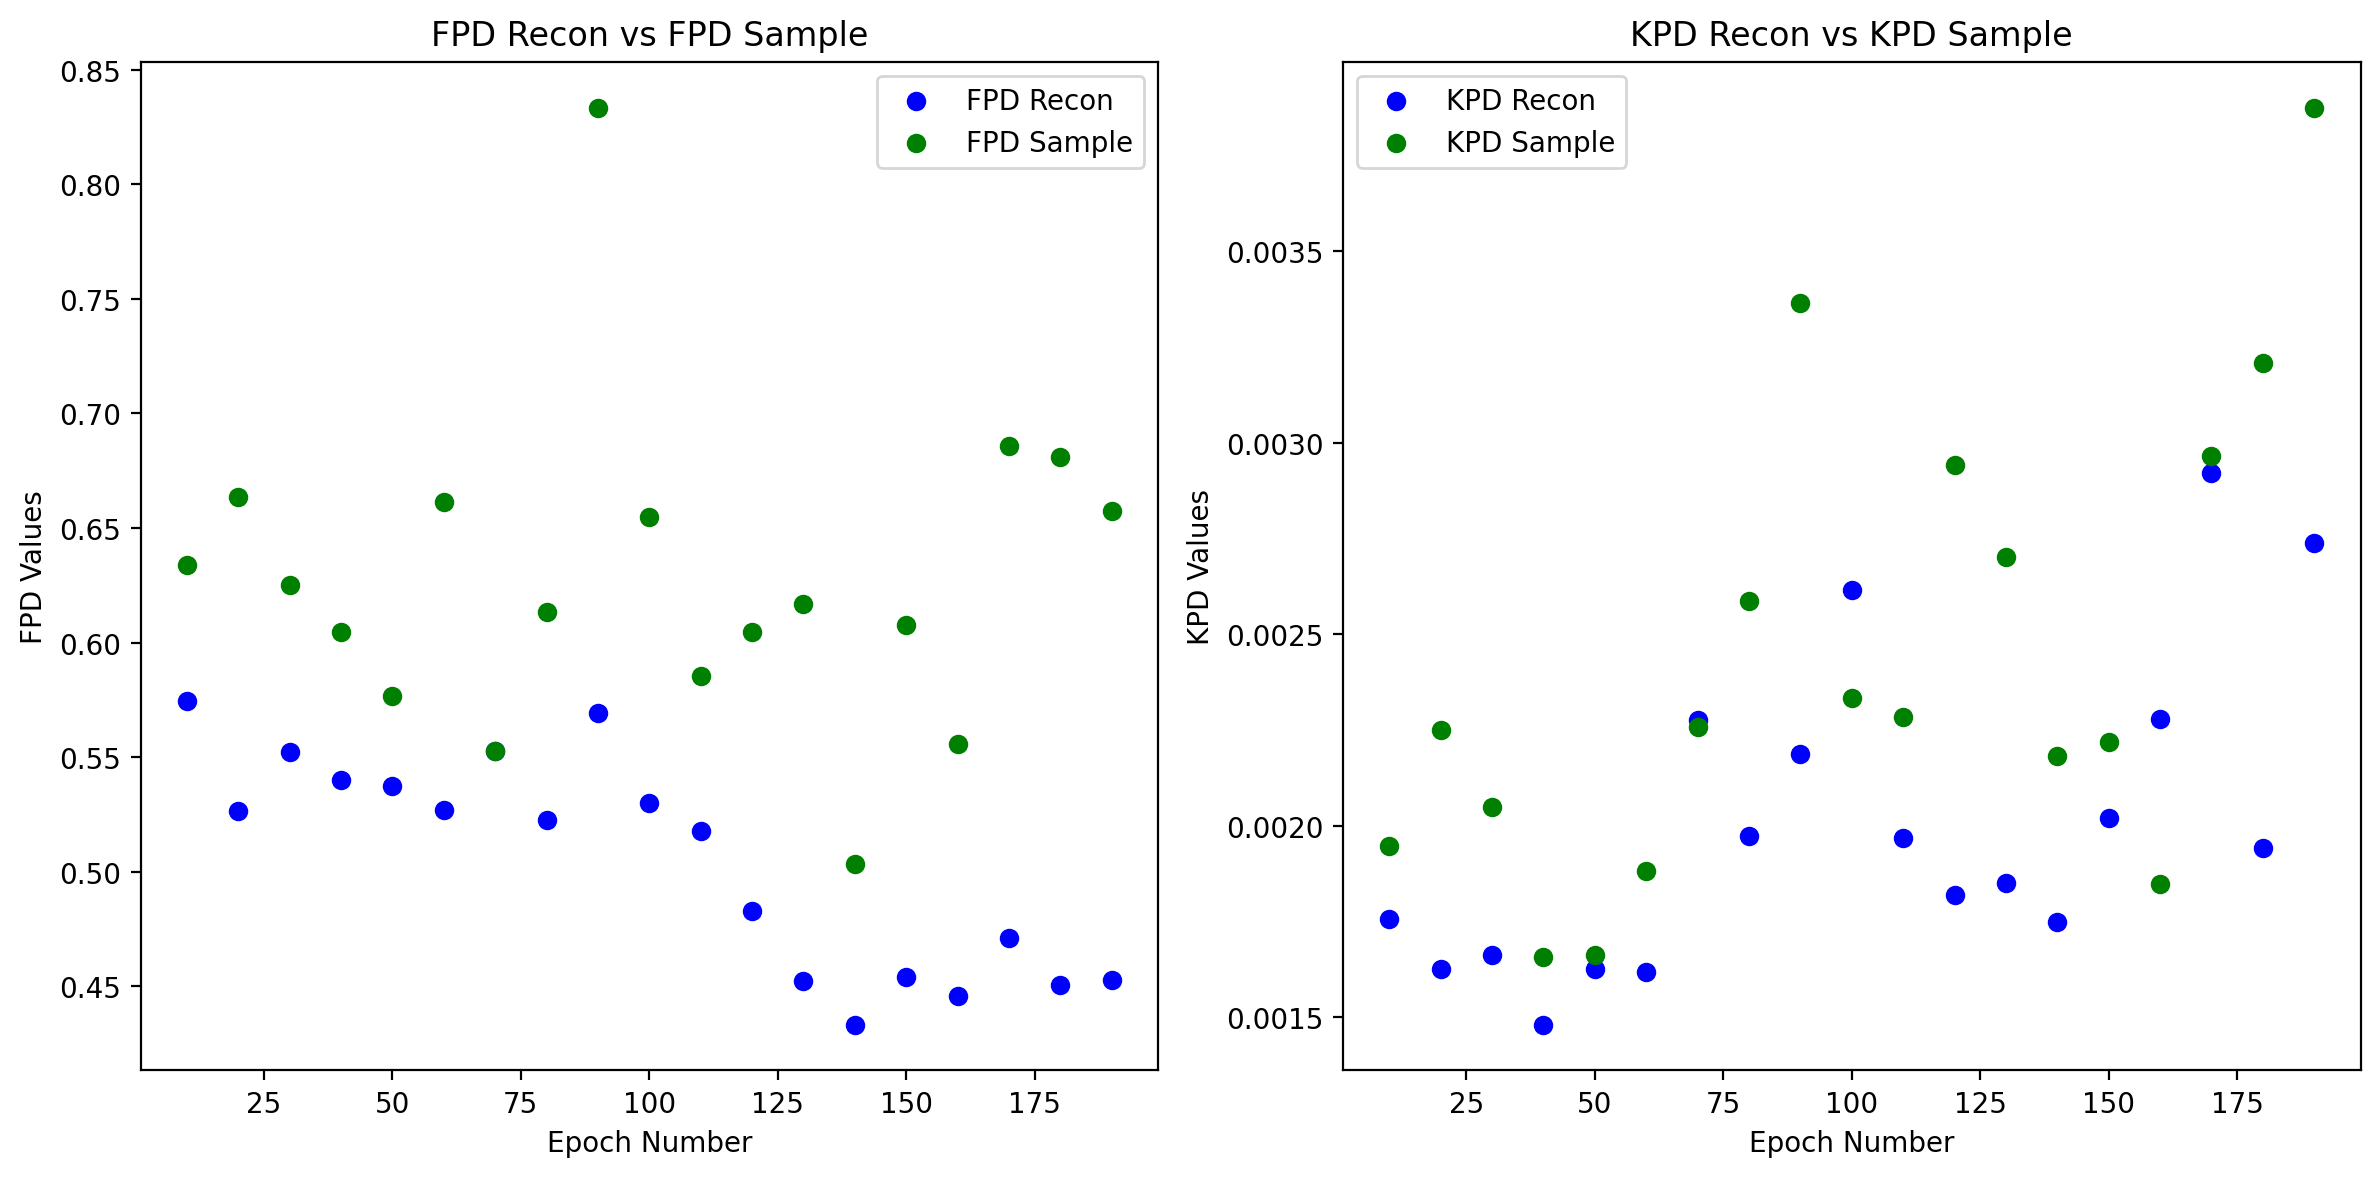

In [14]:
import matplotlib.pyplot as plt

en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample = HEPMetric_output[0], HEPMetric_output[1], HEPMetric_output[2], HEPMetric_output[3], HEPMetric_output[4]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

print(fpd_recon, kpd_recon, fpd_sample, kpd_sample)

# Plot fpd_recon and fpd_sample on ax1
ax1.scatter(en_list, fpd_recon, color='blue', label='FPD Recon')
ax1.scatter(en_list, fpd_sample, color='green', label='FPD Sample')
ax1.set_xlabel('Epoch Number')
ax1.set_ylabel('FPD Values')
ax1.set_title('FPD Recon vs FPD Sample')
ax1.legend()

# Plot kpd_recon and kpd_sample on ax2
ax2.scatter(en_list, kpd_recon, color='blue', label='KPD Recon')
ax2.scatter(en_list, kpd_sample, color='green', label='KPD Sample')
ax2.set_xlabel('Epoch Number')
ax2.set_ylabel('KPD Values')
ax2.set_title('KPD Recon vs KPD Sample')
ax2.legend()

plt.tight_layout()
plt.show()

20 20
[0.5743715983153219, 0.5266812542594178, 0.5524067573211366, 0.5399575982153986, 0.5375374725715795, 0.5269179676968201, 0.552643356988102, 0.5224038885797831, 0.5692257924722228, 0.5298427687811916, 0.5177034000940408, 0.4829729210669462, 0.45242500845079003, 0.4332480364548266, 0.45409619689003494, 0.44583834045574555, 0.4709292939792628, 0.45056004350856876, 0.4528339942851846] [0.0017563925826338256, 0.0016265386498541812, 0.0016619221637470538, 0.0014802270747735768, 0.001626013405347404, 0.0016162860108199784, 0.002274886758550254, 0.001972656511584736, 0.0021880781172956, 0.0026141254190283902, 0.0019679367964804406, 0.0018194716985215909, 0.0018493217520527683, 0.0017468910721973874, 0.0020196942434824727, 0.0022787637853538545, 0.0029203396302011075, 0.0019405812979278458, 0.002738627709647945] [0.6340750192643474, 0.6634647937340336, 0.6250826561705985, 0.604657453152671, 0.5768301233552284, 0.661369383114132, 0.5528745806728821, 0.6132791487678578, 0.8335492874686207, 

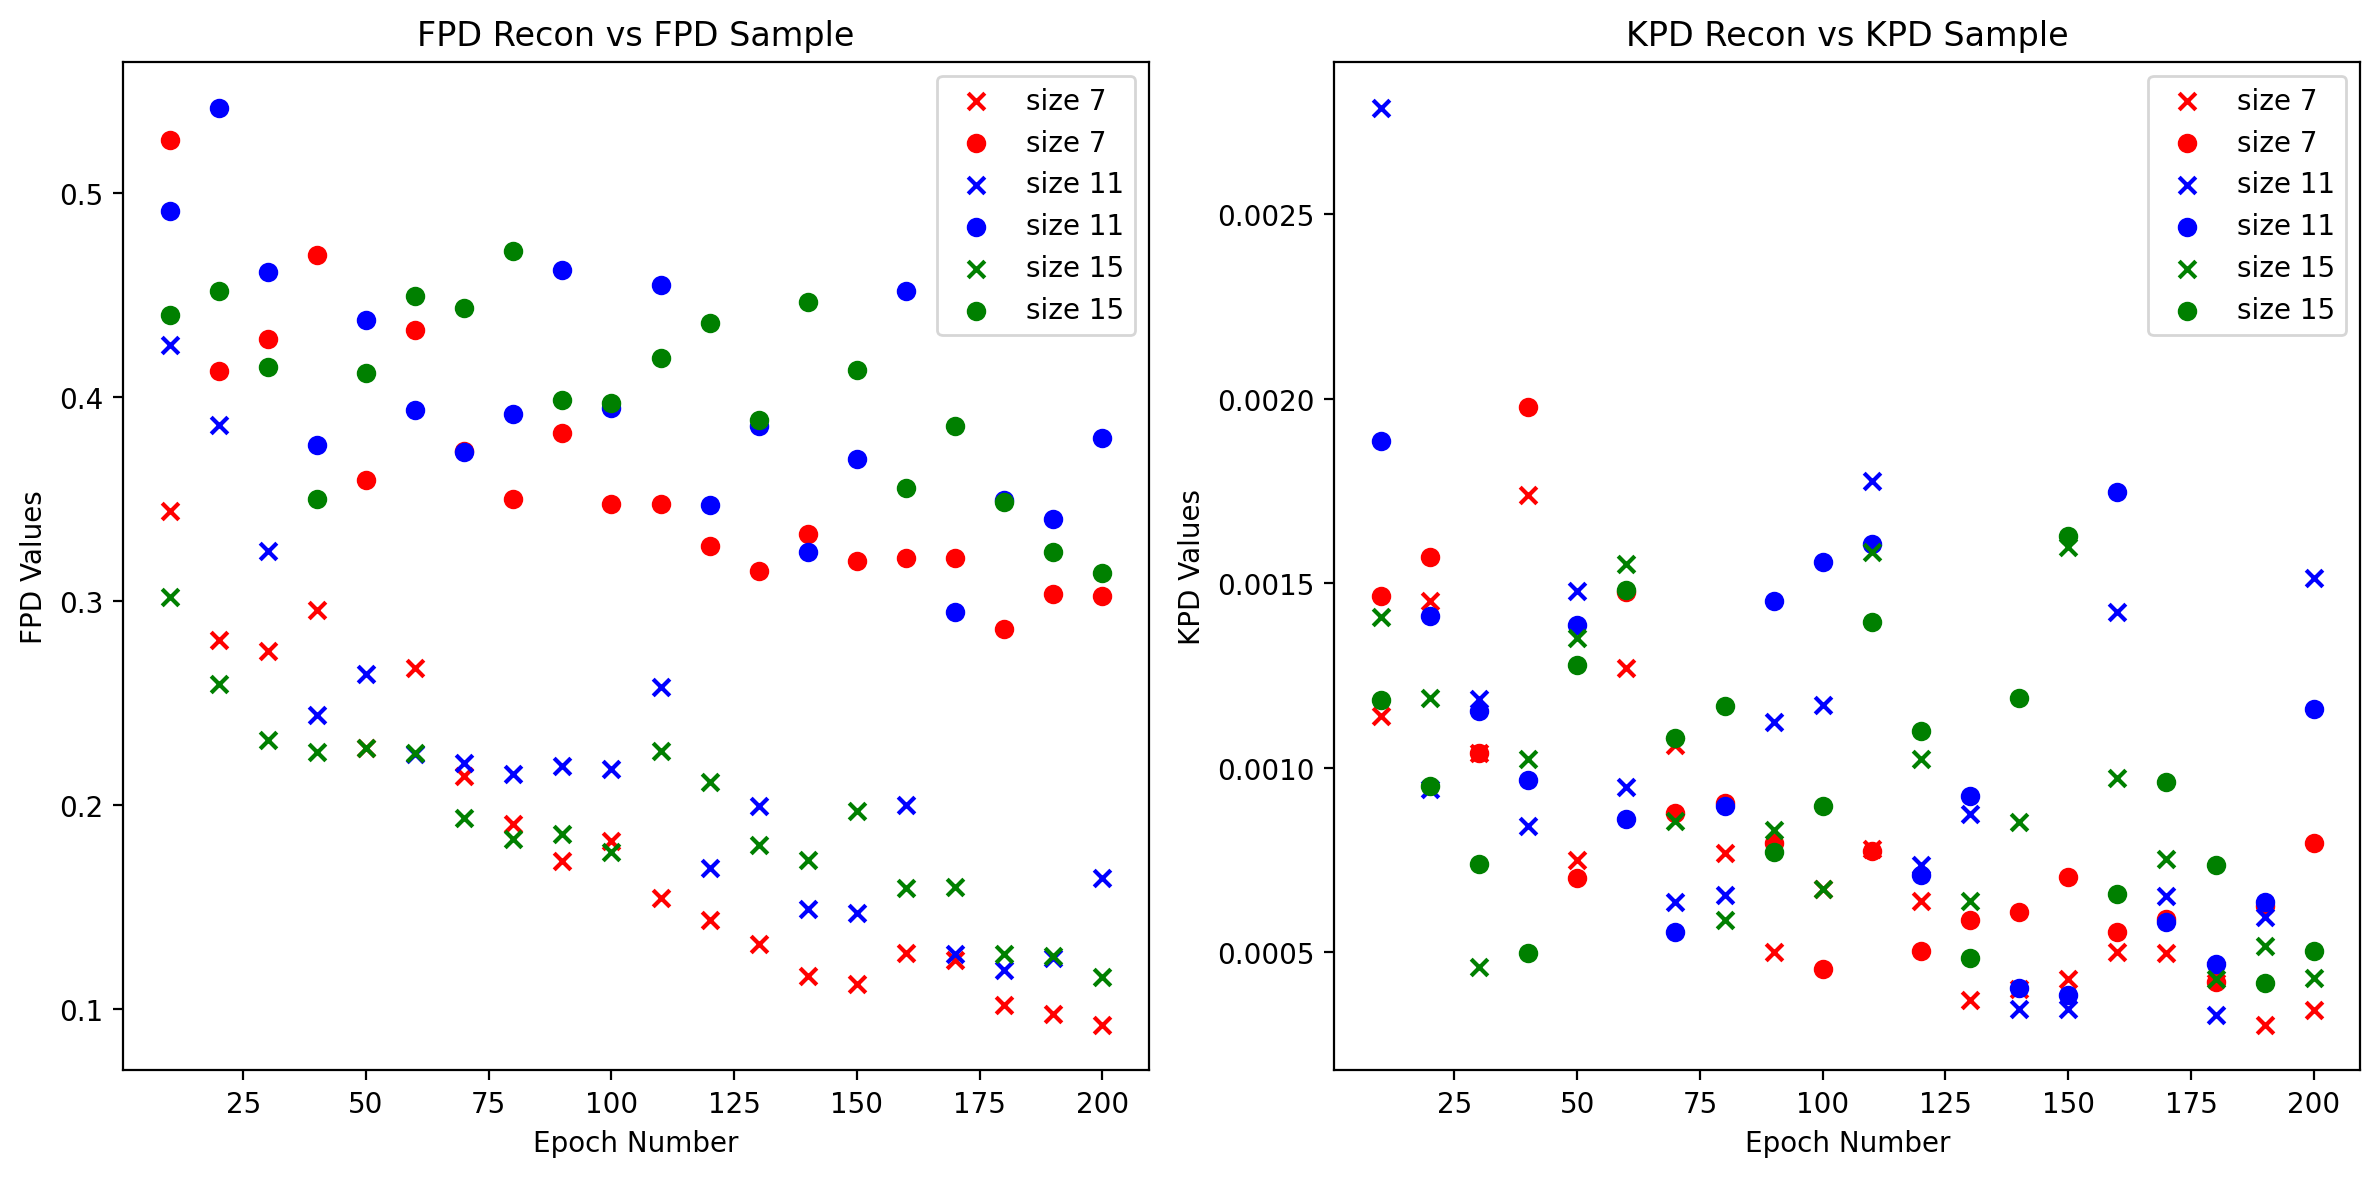

In [26]:
import matplotlib.pyplot as plt

en_list, fpd_recon, kpd_recon, fpd_sample, kpd_sample = HEPMetric_output[0], HEPMetric_output[1], HEPMetric_output[2], HEPMetric_output[3], HEPMetric_output[4]

fpd_recon_11, kpd_recon_11, fpd_sample_11, kpd_sample_11 = [0.4254631251479604, 0.3863241957002061, 0.3247455287884279, 0.24401124285073567, 0.2643416758905999, 0.22524767463329892, 0.220488541796704, 0.2151800808924506, 0.21901001824239458, 0.21789036421944138, 0.25767800439346494, 0.169416229995838, 0.199562758272098, 0.14934963888115677, 0.14728488681424484, 0.20008108303505942, 0.12709425475829034, 0.11954005641398109, 0.1254363240355747, 0.1645445034838319], [0.002789596911044745, 0.0009441447536115977, 0.0011857029012276588, 0.0008414557211733342, 0.0014801244732673968, 0.0009475659738638065, 0.0006367283323096551, 0.000654981624775397, 0.0011253875020820203, 0.001170651608875195, 0.0017761656945662896, 0.0007372023168130681, 0.0008745904492195589, 0.0003469169816976425, 0.00034580128184868997, 0.0014221732062389414, 0.0006529264829622239, 0.0003311457768246928, 0.0005962748366714621, 0.0015138457053798238], [0.4910321689992311, 0.5416755090379743, 0.4612467634821198, 0.37644527552669005, 0.4376873809755184, 0.3933221868110005, 0.3732158307829914, 0.3913965620835585, 0.4621348018181447, 0.39451891012053664, 0.45454909600098536, 0.34697219295766446, 0.38593692067480023, 0.32403264240122487, 0.3697413022869817, 0.45199680960384303, 0.29471034346350045, 0.3494836883278955, 0.3402880941324887, 0.37960240978595305], [0.0018858727681447807, 0.001411492798250924, 0.0011551820409927416, 0.000967400944931418, 0.0013860062098931536, 0.000862127945888691, 0.0005551094671050194, 0.0008957097980155648, 0.0014513057970435561, 0.001557679597950612, 0.0016058958712741322, 0.0007095581493345993, 0.00092328662189467, 0.00040234310211451074, 0.00038522640527971497, 0.0017484927625166513, 0.0005820965118592536, 0.00046950472808382493, 0.0006358738820089194, 0.0011594258318259332]
fpd_recon_15, kpd_recon_15, fpd_sample_15, kpd_sample_15 = [0.3019238989420316, 0.2593383551083405, 0.23185789406244892, 0.22623627243366898, 0.22785611795724936, 0.22558158744745935, 0.19381478985411724, 0.1836949655708134, 0.18581910881718952, 0.17701213232019772, 0.22653350138159375, 0.21133242844750622, 0.18030485045393765, 0.1734341994545681, 0.19722994653588605, 0.1594637796270001, 0.1598435438202664, 0.12723685037039384, 0.12642731415051955, 0.11590968015553642], [0.0014078467808800177, 0.0011902079031567148, 0.0004596757914443472, 0.0010228115242205682, 0.001352888812670816, 0.001552644865958852, 0.000855176428744775, 0.0005880459837146468, 0.0008325807032052435, 0.0006722583323679476, 0.001585947228228246, 0.0010250909666984498, 0.0006389349805384636, 0.0008546601849104274, 0.001598883087666092, 0.0009727237711898429, 0.0007536722401526585, 0.00042820171741131396, 0.000517511956047656, 0.0004302994502440871], [0.4399175471130753, 0.45172476119375693, 0.41482979608838316, 0.34978094543883703, 0.41150044040644657, 0.449423840380588, 0.4435374981632099, 0.4712948696707354, 0.39855711270821736, 0.396822169349394, 0.41879384784283197, 0.43629229316696355, 0.3887370388040963, 0.4463720223193526, 0.4133026629116395, 0.3553947619748474, 0.3856060179956842, 0.3484281602256485, 0.32380064398261554, 0.31361221485895363], [0.0011837517084292148, 0.000949603039759106, 0.0007394687177171289, 0.0004995694732732314, 0.001278930603390016, 0.0014815237118210867, 0.0010814986298870455, 0.0011690815519385112, 0.0007731751509696405, 0.0008963589322190657, 0.0013949854502626202, 0.0011003302876004817, 0.0004847561860608085, 0.001189560789948807, 0.0016288879363208775, 0.0006587308201360109, 0.0009630135907607862, 0.0007377992351069729, 0.0004166138129328978, 0.0005035537200246409]
fpd_recon_7, kpd_recon_7, fpd_sample_7, kpd_sample_7 = [0.3443265982956043, 0.2807222047910817, 0.2757433748913746, 0.29571222905017613, 0.2278632655323166, 0.26728961075753005, 0.21457047342215926, 0.19076019788270482, 0.17268513518050777, 0.18269869509509043, 0.1545314802788361, 0.14377719499377623, 0.13184473037980288, 0.1161674663316766, 0.11235210918332428, 0.12750423816174697, 0.12426023045640053, 0.10207775511239257, 0.09785014107937617, 0.09259484425299055], [0.0011395584132993797, 0.001453290601438173, 0.0010401016171155408, 0.0017396070321622492, 0.0007496637932626893, 0.0012715529948765791, 0.0010609646450225885, 0.000769021391776592, 0.0005004954434659759, 0.0006710932600113573, 0.0007814343709844351, 0.0006392766888265733, 0.0003707799674825818, 0.00040130424773021645, 0.0004270382691247132, 0.000501783952513879, 0.0004979863523311145, 0.00045454841278558256, 0.00030436200676864367, 0.0003427283393580005], [0.5257284124938946, 0.4124494803636761, 0.42818361024676516, 0.46936289865785424, 0.3590682192069662, 0.4327680558783181, 0.3733214435381841, 0.3497676069581265, 0.38205655615971323, 0.34745970663548587, 0.34749552432423525, 0.3267216863507488, 0.314938251890331, 0.3329086859446169, 0.31966178112835447, 0.32103614424082616, 0.32106903751891275, 0.28616358397778946, 0.30338755056745315, 0.30234314365930265], [0.0014663909917407292, 0.0015721883030157535, 0.0010407489203456688, 0.001978750828149689, 0.0007025563456992678, 0.0014763864929343562, 0.0008776226707285506, 0.0009041523348072289, 0.0007964012041257185, 0.0004543177288944822, 0.0007739827826651613, 0.0005032777669149446, 0.0005891515093159327, 0.0006104731753342474, 0.0007046187159869266, 0.000554774384400547, 0.0005911569832333097, 0.0004207202158397205, 0.0006267792227441227, 0.0007959838711006917]

en_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
print(len(en_list), len(fpd_recon_11))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

print(fpd_recon, kpd_recon, fpd_sample, kpd_sample)

# Plot fpd_recon and fpd_sample on ax1
ax1.scatter(en_list, fpd_recon_7, color='red', label='size 7', marker = 'x')
ax1.scatter(en_list, fpd_sample_7, color='red', label='size 7')
ax1.scatter(en_list, fpd_recon_11, color='blue', label='size 11', marker = 'x')
ax1.scatter(en_list, fpd_sample_11, color='blue', label='size 11')
ax1.scatter(en_list, fpd_recon_15, color='green', label='size 15', marker = 'x')
ax1.scatter(en_list, fpd_sample_15, color='green', label='size 15')
ax1.set_xlabel('Epoch Number')
ax1.set_ylabel('FPD Values')
ax1.set_title('FPD Recon vs FPD Sample')
ax1.legend()

# Plot kpd_recon and kpd_sample on ax2
ax2.scatter(en_list, kpd_recon_7, color='red', label='size 7', marker = 'x')
ax2.scatter(en_list, kpd_sample_7, color='red', label='size 7')
ax2.scatter(en_list, kpd_recon_11, color='blue', label='size 11', marker = 'x')
ax2.scatter(en_list, kpd_sample_11, color='blue', label='size 11')
ax2.scatter(en_list, kpd_recon_15, color='green', label='size 15', marker = 'x')
ax2.scatter(en_list, kpd_sample_15, color='green', label='size 15')
ax2.set_xlabel('Epoch Number')
ax2.set_ylabel('KPD Values')
ax2.set_title('KPD Recon vs KPD Sample')
ax2.legend()

plt.tight_layout()
plt.show()

[0.5743715983153219, 0.5266812542594178, 0.5524067573211366, 0.5399575982153986, 0.5375374725715795, 0.5269179676968201, 0.552643356988102, 0.5224038885797831, 0.5692257924722228, 0.5298427687811916, 0.5177034000940408, 0.4829729210669462, 0.45242500845079003, 0.4332480364548266, 0.45409619689003494, 0.44583834045574555, 0.4709292939792628, 0.45056004350856876, 0.4528339942851846] [0.0017563925826338256, 0.0016265386498541812, 0.0016619221637470538, 0.0014802270747735768, 0.001626013405347404, 0.0016162860108199784, 0.002274886758550254, 0.001972656511584736, 0.0021880781172956, 0.0026141254190283902, 0.0019679367964804406, 0.0018194716985215909, 0.0018493217520527683, 0.0017468910721973874, 0.0020196942434824727, 0.0022787637853538545, 0.0029203396302011075, 0.0019405812979278458, 0.002738627709647945] [0.6340750192643474, 0.6634647937340336, 0.6250826561705985, 0.604657453152671, 0.5768301233552284, 0.661369383114132, 0.5528745806728821, 0.6132791487678578, 0.8335492874686207, 0.6547

NameError: name 'fpd_recon_5' is not defined

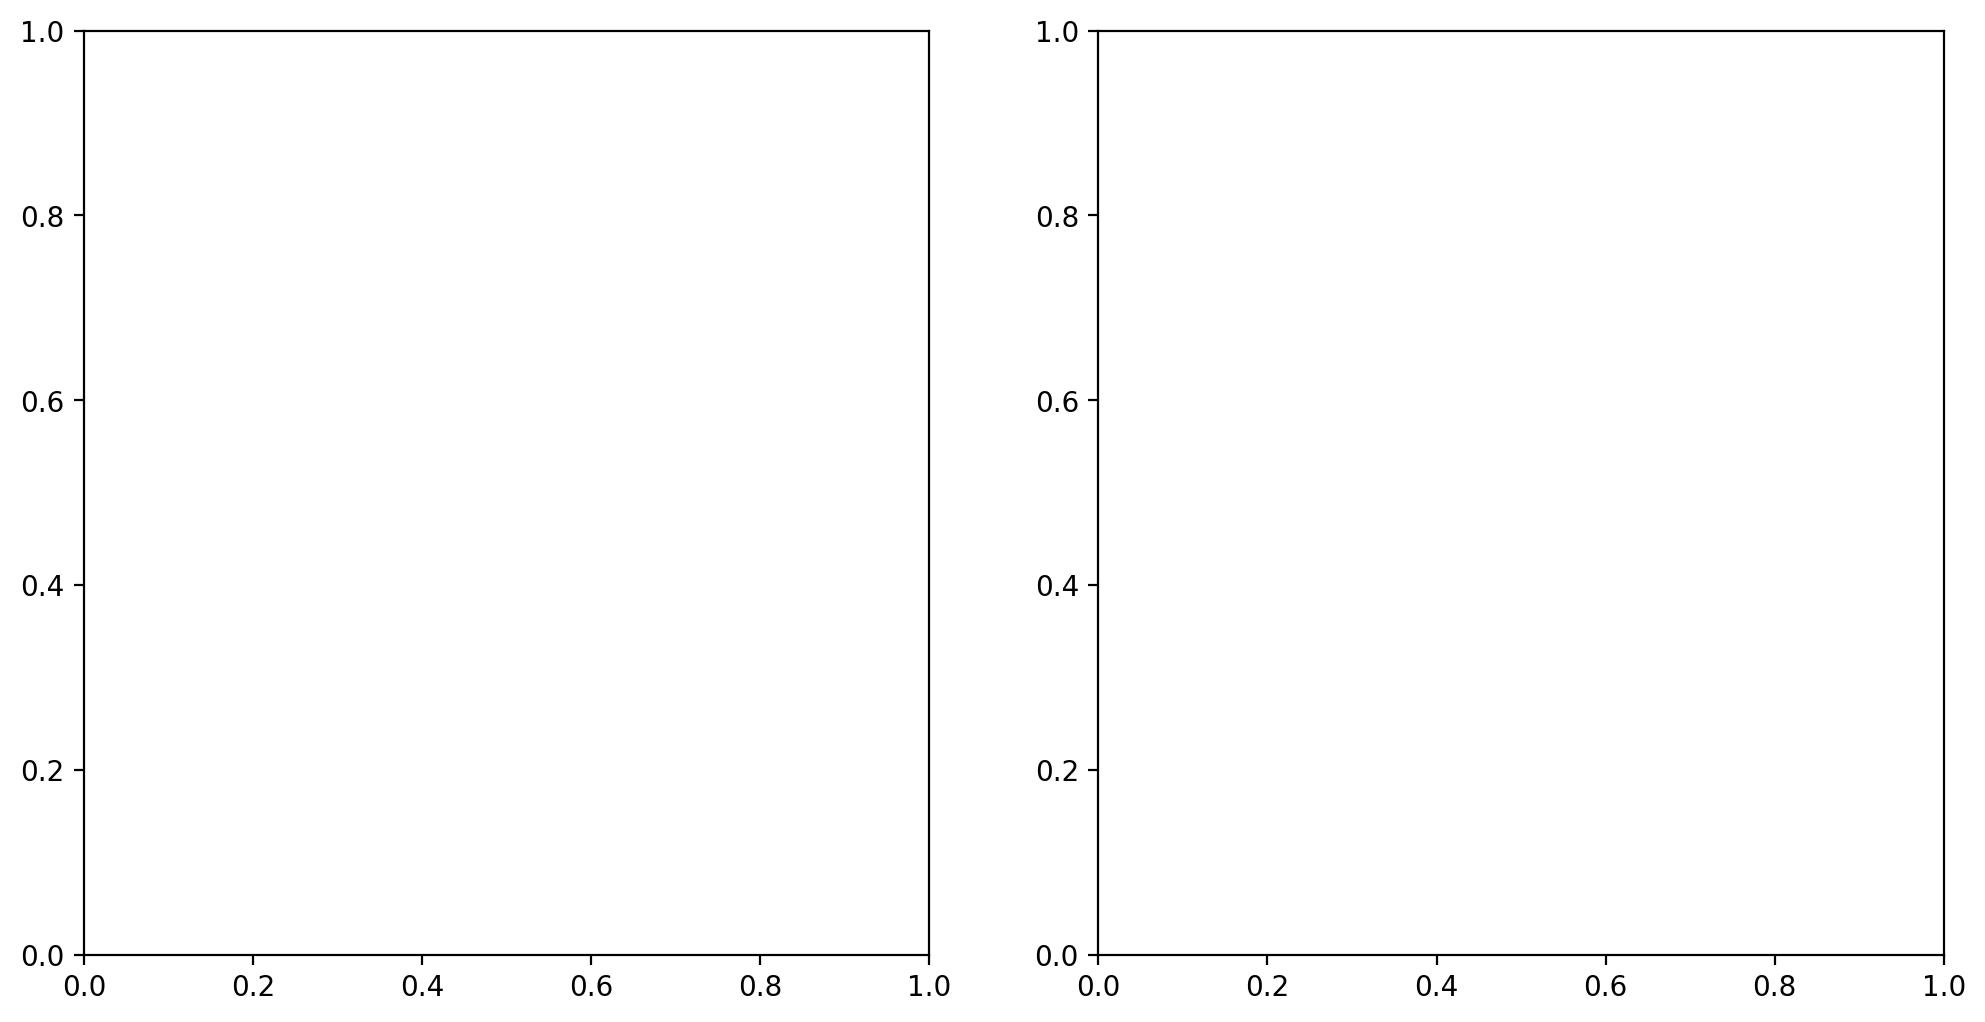

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

print(fpd_recon, kpd_recon, fpd_sample, kpd_sample)

# Plot fpd_recon and fpd_sample on ax1
ax1.scatter(en_list, fpd_recon_5, color='blue', label='size 5')
ax1.scatter(en_list, fpd_recon_8, color='green', label='size 8')
ax1.scatter(en_list, fpd_recon_11, color='red', label='size 11')
ax1.scatter(en_list, fpd_recon_14, color='orange', label='size 14')
ax1.set_xlabel('Epoch Number')
ax1.set_ylabel('FPD Values')
ax1.set_title('FPD Recon vs FPD Sample')
ax1.legend()

# Plot kpd_recon and kpd_sample on ax2
ax2.scatter(en_list, kpd_recon_5, color='blue', label='size 5')
ax2.scatter(en_list, kpd_recon_8, color='green', label='size 8')
ax2.scatter(en_list, kpd_recon_11, color='red', label='size 11')
ax2.scatter(en_list, kpd_recon_14, color='orange', label='size 14')
ax2.set_xlabel('Epoch Number')
ax2.set_ylabel('KPD Values')
ax2.set_title('KPD Recon vs KPD Sample')
ax2.legend()

plt.tight_layout()
plt.show()